In [1]:
import numpy
import skimage
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import sys

In [2]:
import pyphantom

# Hot-rod (Derenzo) Phantom

In [3]:
phantom=pyphantom.phantoms.generator.get_phantom('derenzo',shape=(200,200))

Produce derenzo phantom, with dimension 200x200
nlayers: [18 12  9  6  5  5]


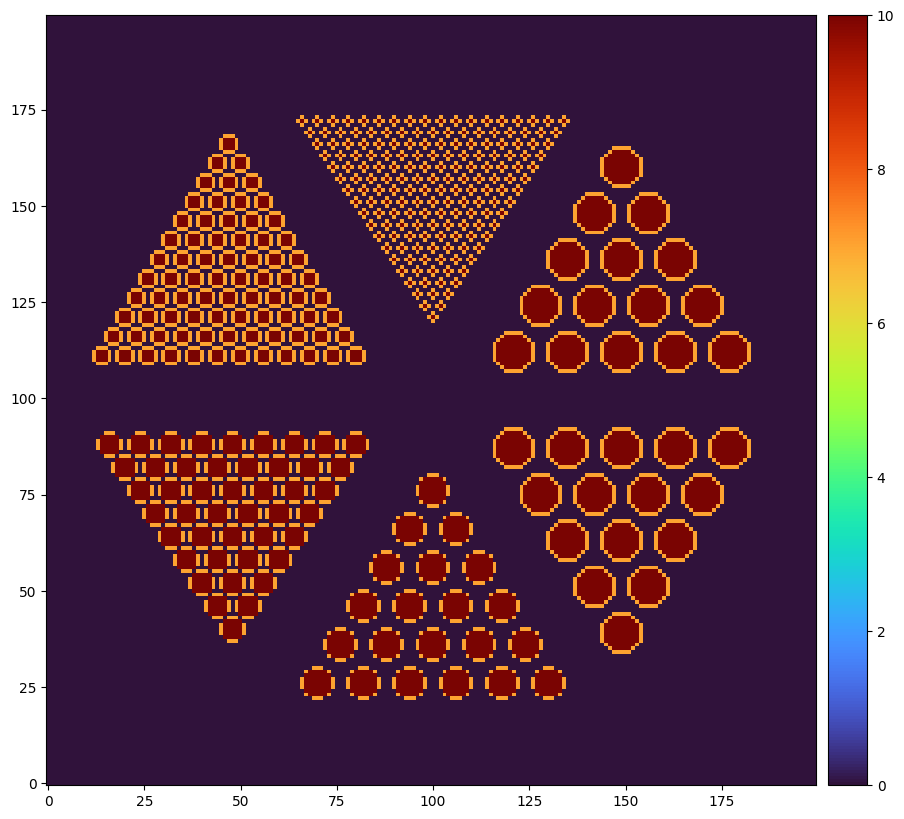

In [4]:
fig, ax = plt.subplots(figsize=(16, 10), dpi=100)
norm = plt.Normalize(0, 10)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white", "orange"])
cbar = fig.colorbar(
    ax.imshow(phantom.image.T, origin="lower", cmap=mpl.colormaps['turbo'], norm=norm, aspect="equal"), pad=0.01
)

In [ ]:
img = np.zeros((180, 180))
mask = np.zeros((180, 180))
radii = [2,4,6,8,10,12]
R=55
for idx in range(0,6):
    angle_rad = idx*math.pi/3
    cx,cy = (math.cos(angle_rad)*R+90,math.sin(angle_rad)*R+90)
    xx,yy = skimage.draw.circle_perimeter(int(cx),int(cy),radii[idx])
    img[xx,yy] = 5
    mask[xx,yy] = idx+1
    xx,yy = skimage.draw.disk((int(cx),int(cy)),radii[idx])
    img[xx,yy] = 10
    mask[xx,yy] = idx+1


In [ ]:
fig,ax = plt.subplots(figsize=(16,10),dpi=100)
norm=plt.Normalize(0,10)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","orange"])
fig.colorbar(ax.imshow(img.T,origin='lower',cmap=cmap,norm=norm))


In [ ]:
dataDir = "/home/fanghan/Work/SPEBT/Develop/data/2023/"
NImgX_ = 180
NImgY_ = 180
NDetY_ = 32
NModule_ = 6
NDetX_ = 24
fName = (
    "sysmat_24layer_Rot_0_of_2_2mmslitin10mm_1010_idxT0_numT1in1mm_IZ0_DZ0_100.sysmat"
)
data = np.fromfile("%s%s" % (dataDir, fName), dtype="single")
dataArr2D= data.reshape((NDetX_ * NModule_ * NDetY_, NImgX_ * NImgY_))
dataArr5D = dataArr2D.reshape((NDetX_, NModule_, NDetY_, NImgX_, NImgY_))

In [ ]:
print(sys.getsizeof(data)/1024/1024,"MB")

In [ ]:
Nlayers = 1
sysmat = np.reshape(dataArr5D[:Nlayers,:,:,:,:],(Nlayers,NModule_,NDetY_,NImgX_ * NImgY_))

In [ ]:
# 500 Bq/uL, 30s
# 10 * 1500 Count/uL

poisson_img = np.random.poisson(img*1500)
arr_dict={}
for Nlayers in range(1, 11):
    dataMat = np.reshape(dataArr5D[:Nlayers, :, :, :, :],(Nlayers*NModule_*NDetY_,NImgX_ * NImgY_))
    sysmat = dataMat[~np.all(dataMat == 0, axis=1)]
    fake_proj = np.matmul(sysmat, poisson_img.reshape(NImgX_ * NImgY_))
    arr_dict['%d-layers'%Nlayers] = fake_proj
    print(fake_proj.shape)
# for keys in arr_dict:
#     print(arr_dict[keys].shape)
np.savez("test.npz",**arr_dict)

In [ ]:
npzfile = np.load("test.npz")
sorted(npzfile.files)

# Test reconstruction

In [ ]:
Nlayers=8
dataMat = np.reshape(dataArr5D[:Nlayers, :, :, :, :],(Nlayers*NModule_*NDetY_,NImgX_ * NImgY_))
# print(dataMat.shape)
sysmat = dataMat[~np.all(dataMat == 0, axis=1)]
print(sysmat.shape)

In [ ]:
def backwardProj(lastArr, projArr, sysMat):
    forwardLast = np.matmul(sysMat, lastArr)
    quotients = projArr/forwardLast
    return np.matmul(quotients, sysMat)/np.sum(sysMat, axis=0)*lastArr

In [ ]:

Nlayers=8
dataMatrix = np.reshape(dataArr5D[:Nlayers, :, :, :, :],(Nlayers*NModule_*NDetY_,NImgX_ * NImgY_))
sysMatrix = dataMatrix[~np.all(dataMatrix == 0, axis=1)]
matSum = np.sum(sysMatrix, axis=0, dtype=float)
validIdx = np.array(np.where(matSum != 0))
# validIdx=np.where(matSum != 0)
reducedMat = np.reshape(
    sysMatrix[:, validIdx], (sysMatrix.shape[0], validIdx.shape[1]))
projection = np.random.poisson(arr_dict['%d-layers'%Nlayers])
print(projection.shape)


In [ ]:
result = projection == np.floor(projection)
np.alltrue(result)

In [ ]:
poisson_img = np.random.poisson(img*1500)
fig,ax = plt.subplots(figsize=(16,10),dpi=100)
# norm=plt.Normalize(0,10)
# cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","orange"])
fig.colorbar(ax.imshow(poisson_img.T,origin='lower'))

In [ ]:
def myfunc(k,mean):
    return mean**k * math.exp(-mean)/math.factorial(k)
vmyfunc = np.vectorize(myfunc)

def my_log_gaus(xx,mean):
    return np.log(1/np.sqrt(2*3.1416*mean)*np.exp(-(xx-mean)**2/(2*mean)))

In [ ]:
print(np.mean(projection),np.std(projection))

In [ ]:
NIteration = 50
print((reducedMat.shape))
reconImg = np.ones(reducedMat.shape[1])*200
for iter in range(NIteration):
        reconImg = backwardProj(reconImg, projection, reducedMat)
        probs = my_log_gaus(projection,np.matmul(reducedMat,reconImg))
        print(np.sum(probs))

In [ ]:
ks = np.arange(1,5)
means = np.array([0.5,2.1,3.6,4.7])
vmyfunc = np.vectorize(myfunc)
print(vmyfunc(ks,means))
for k,mean in zip(ks,means):
    print(myfunc(k,mean))

In [ ]:
fig,ax = plt.subplots(figsize=(16,10),dpi=100)
plotImg = np.zeros((NImgX_ * NImgY_))
plotImg[validIdx] = reconImg
# norm=plt.Normalize(0,10)
# cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","orange"])
fig.colorbar(ax.imshow(np.reshape(plotImg,(NImgX_,NImgY_)).T,origin='lower'))

In [ ]:

NIteration = 100
Nlayers=2
dataMatrix = np.reshape(dataArr5D[:Nlayers, :, :, :, :],(Nlayers*NModule_*NDetY_,NImgX_ * NImgY_))
sysMatrix = dataMatrix[~np.all(dataMatrix == 0, axis=1)]
matSum = np.sum(sysMatrix, axis=0, dtype=float)
validIdx = np.array(np.where(matSum != 0))
# validIdx=np.where(matSum != 0)
reducedMat = np.reshape(
    sysMatrix[:, validIdx], (sysMatrix.shape[0], validIdx.shape[1]))
projection = np.random.poisson(arr_dict['%d-layers'%Nlayers])

reconImg = np.ones(reducedMat.shape[1])*200
for iter in range(NIteration):
        reconImg = backwardProj(reconImg, projection, reducedMat)
        # probs = my_log_gaus(projection,np.matmul(reducedMat,reconImg))
        # print(np.sum(probs))
fig,ax = plt.subplots(figsize=(16,10),dpi=100)
plotImg = np.zeros((NImgX_ * NImgY_))
plotImg[validIdx] = reconImg
# norm=plt.Normalize(0,10)
# cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","orange"])
fig.colorbar(ax.imshow(np.reshape(plotImg,(NImgX_,NImgY_)).T,origin='lower'))

In [ ]:
NIteration = 100
for Nlayers in range(1,10):
    dataMatrix = np.reshape(dataArr5D[:Nlayers, :, :, :, :],(Nlayers*NModule_*NDetY_,NImgX_ * NImgY_))
    sysMatrix = dataMatrix[~np.all(dataMatrix == 0, axis=1)]
    matSum = np.sum(sysMatrix, axis=0, dtype=float)
    validIdx = np.array(np.where(matSum != 0))
    reducedMat = np.reshape(
        sysMatrix[:, validIdx], (sysMatrix.shape[0], validIdx.shape[1]))
    projection = np.random.poisson(arr_dict['%d-layers'%Nlayers])

    reconImg = np.ones(reducedMat.shape[1])*200
    for iter in range(NIteration):
            reconImg = backwardProj(reconImg, projection, reducedMat)
    fig,ax = plt.subplots(figsize=(16,10),dpi=100)
    plotImg = np.zeros((NImgX_ * NImgY_))
    plotImg[validIdx] = reconImg
    mytext="N x-layers: %2d"% Nlayers
    ax.annotate(mytext,
                xy=(2, 175), xycoords='data',fontsize=18,
                horizontalalignment='left',
                verticalalignment='center',color="white")
    ax.tick_params(labelsize=12)
    fig.colorbar(ax.imshow(np.reshape(plotImg,(NImgX_,NImgY_)).T,origin='lower'),pad=0.01)
    plt.tight_layout()
    fig.savefig("%d-x-layers-recon.png"%Nlayers)

In [ ]:
img = np.zeros((imgN_x_,imgN_y_))
img[89,89]=10
fig, ax = plt.subplots(figsize=(11, 10), dpi=100)
norm = plt.Normalize(0, 10)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white", "orange"])
cbar = fig.colorbar(
    ax.imshow(
        img.T, origin="lower", cmap=mpl.colormaps["gray"], norm=norm, aspect="equal"
    ),
    pad=0.01,
)

In [ ]:
import os
outDir='output/'
if os.path.exists(outDir)!= True:
    try:
        os.mkdir(outDir)
    except Exception as err:
        print(err)
        exit(2)
outImgName='dot_phantom_plot_%dx%d.png'%(imgN_x_,imgN_y_)
outNpzName='dot_phantom_data_%dx%d.npz'%(imgN_x_,imgN_y_)
print("Save phantom plot to",outDir+outImgName)
fig.savefig(outDir+outImgName,dpi=100)
print("Save phantom data to",outDir+outNpzName)
np.savez_compressed(outDir+outNpzName,phantom=img,mask=mask)